In [3]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

listings = pd.read_csv("listings.csv")

df = listings[['price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month',
               'calculated_host_listings_count', 'availability_365']].copy()

df = df[df['price'] > 0]
df = df.dropna()

In [5]:
X = df.drop('price', axis=1)
y = df['price']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA()
X_pca = pca.fit_transform(X_scaled)

explained_variance = pca.explained_variance_ratio_

n_components_80 = np.argmax(np.cumsum(explained_variance) >= 0.80) + 1

X_pca_selected = X_pca[:, :n_components_80]

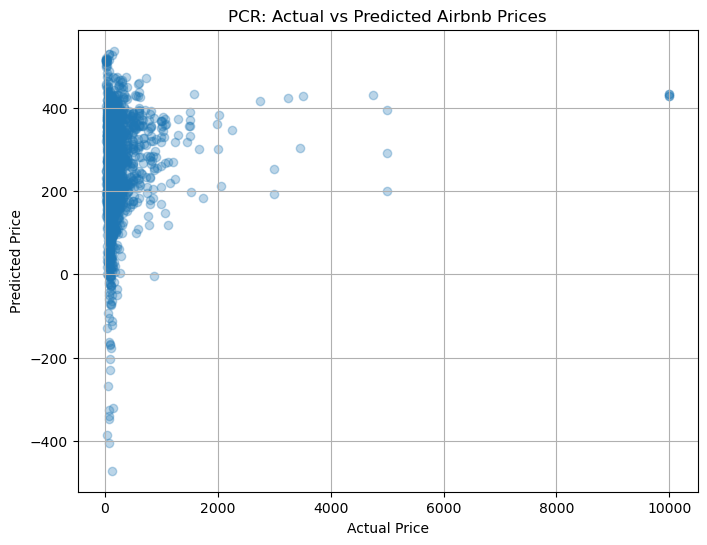

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_pca_selected, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("PCR: Actual vs Predicted Airbnb Prices")
plt.grid(True)
plt.show()

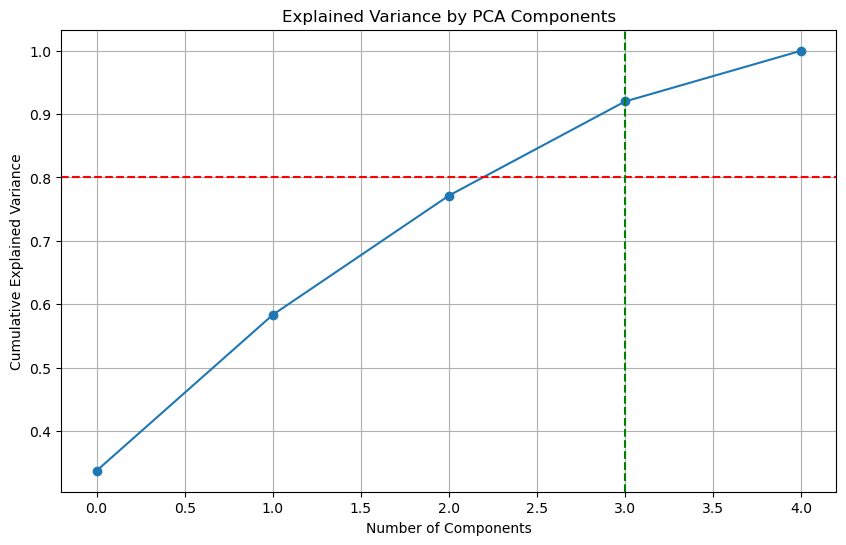

,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
PC1,-0.304855,0.645520,0.662878,-0.194405,-0.114748
PC2,-0.086250,0.109129,0.173464,0.672327,0.706072
PC3,0.932184,0.304178,0.127252,-0.088784,0.120135
PC4,0.116516,0.103623,0.041620,0.708683,-0.686821


In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(explained_variance), marker='o')
plt.axhline(y=0.8, color='r', linestyle='--')
plt.axvline(x=n_components_80-1, color='g', linestyle='--')
plt.title("Explained Variance by PCA Components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid(True)
plt.show()

component_df = pd.DataFrame(
    pca.components_[:n_components_80],
    columns=X.columns,
    index=[f'PC{i+1}' for i in range(n_components_80)]
)

component_df

-I used PCA to reduce the dimensionality of the features before applying linear regression—basically squashing the predictors into principal components that still preserve the variance.

-Looks like we only needed the first 4 principal components to explain about 80% of the variance, so the dimensionality reduction worked nicely.

-The PCR model got a decent R2 score, though not a huge jump in accuracy over basic models—probably because pricing is still influenced by stuff we don’t have (like location vibes, interior quality, etc.).

-Component 1 is strongly aligned with reviews_per_month and number_of_reviews, which kind of confirms these are important volume/activity metrics.

-Component 2’s loadings are heavy on availability_365 and calculated_host_listings_count—looks like host behavior and availability patterns form their own factor.

-Overall, this gave me a clearer look at underlying structure in the Airbnb data, which helps us build intuition on what combinations of variables really move together.

-We didn’t overfit thanks to dimensionality reduction + standard train/test split.